In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import os

In [2]:
# Function to evaluate the entropy of a vector
# INPUTS
# - v: vector that contains in each cell the value of a byte (so from 0 to 255)
# - num: number of cells of the vector we want to consider in the analysis (from the first element)
# OUTPUT: entropy value
def entropy(v,num):
    freq = np.zeros(256)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(256):
        if freq[i]>0:
            h = h+(freq[i]/num)*np.log2(freq[i]/num)
    h = -h
    return h

def entropy1(v, num, offset):
    freq = np.zeros(offset)
    for i in range(num):
        freq[int(v[i])]=freq[int(v[i])]+1
    h = 0
    for i in range(offset):
        if freq[i]>0:
            h = h + (freq[i]/num) * np.log2(freq[i]/num)
    h = -h
    return h

# Function to evaluate the entropy of a file as a function of the header lenght
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# - Bytes: total number of bytes we want to consider in the analysis
# OUTPUT: vector that contains the entropy values as a function of the header lenght analyzed
def entropy_analysis(file, Bytes):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy(file,8*i)
    return h_vector

def entropy_analysis1(file, Bytes, offset):
    h_vector = np.zeros(int(Bytes/8)+1)
    for i in range(int(Bytes/8)+1):
        h_vector[i] = entropy1(file, 8*i, offset)
    return h_vector

# Function to evaluate the Area (DDA approach) between two files 
# INPUTS
# - h_1,h_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the area
def diff_area(h_1,h_2):
    area = 0
    length = min(len(h_1),len(h_2))
    diff_vec = np.zeros(length)
    for i in range(length):
        diff_vec[i]=abs(h_1[i]-h_2[i])
    sum = 0
    for i in range(2,length-2):
        sum = sum+2*diff_vec[i]
    area = (8/2)*(diff_vec[1]+diff_vec[len(h_1)-1]+sum)
    return area

# Function to transform the file of the dataset in a vector ready to be analyzed
# INPUTS
# - file: the file from the dataset we want to analyze
# - size: the size of the file we want to cut
# OUTPUT: file vector
def file_to_vector(file, size):
    vec = np.zeros(size)
    for i in range(size):
        vec[i] = int.from_bytes(bytes(file[i], 'latin-1'), byteorder="big")
    return vec

def file_to_vector1(file, start, offset):
    vec = np.zeros(offset)
    for i in range(offset):
        vec[i] = int.from_bytes(bytes(file[start + i], 'latin-1'), byteorder="big")
    return vec

# Return a vector containing ones, if for different header lengths correctly classify a file, and 0.0 otherwise. y is the correct result (True or False),
def accuracies(threshold, areas, y):
    accuracies=np.zeros([len(areas),1], dtype=float)
    for i in range(len(areas)):
        # True negatives
        if y==False and areas[i] > threshold:
            accuracies[i] = 1.0
        # True positives
        if y==True and areas[i] <= threshold:
            accuracies[i] = 1.0
    return accuracies

def accuracies1(threshold, areas, offset_org, y):
    accuracies = np.zeros([int(offset_org/8)+1,1], dtype=float)
    true_positives = np.zeros([int(offset_org/8)+1,1], dtype=float)
    true_negatives = np.zeros([int(offset_org/8)+1,1], dtype=float)
    false_positives = np.zeros([int(offset_org/8)+1,1], dtype=float)
    false_negatives = np.zeros([int(offset_org/8)+1,1], dtype=float)
    for i in range(len(areas)):
        # True negatives
        if y==False and areas[i] > threshold:
            accuracies[i] = 1.0
            true_negatives[i] = 1.0
        # True positives
        if y==True and areas[i] <= threshold:
            accuracies[i] = 1.0
            true_positives[i] = 1.0
        # False negatives
        if y==False and areas[i] <= threshold:
            false_negatives[i] = 1.0
        # False positives
        if y==True and areas[i] > threshold:
            false_positives[i] = 1.0
    return accuracies, true_positives, true_negatives, false_positives, false_negatives

#analyze the differential area of file_vector from the byte at position start to the byte at position end
def trapezoidal_rule(ideal_file, file_vector):
    area = np.zeros(33)
    # Iterate over the different header lenghts of the file
    for i in range(8, 257, 8):
        h_ideal = entropy_analysis(ideal_file, i)
        h = entropy_analysis(file_vector, i)
        area[int(i/8)] = diff_area(h_ideal,h)
    return area

def trapezoidal_rule1(ideal_file, file_vector, offset):
    area = np.zeros(int(offset/8)+1)
    # Iterate over the different header lenghts of the file
    for i in range(8, offset + 1, 8):
        h_ideal = entropy_analysis1(ideal_file, i, offset)
        h = entropy_analysis1(file_vector, i, offset)
        area[int(i/8)] = diff_area(h_ideal,h)
    return area

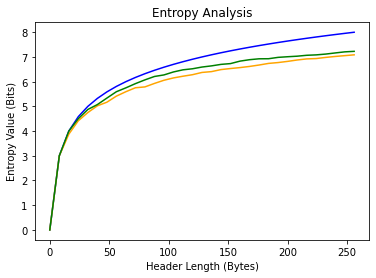

In [3]:
# Creation of an ideal file that will be used as reference for the maximum entropy achievable
ideal_file = np.zeros(256)
for i in range(len(ideal_file)):
    ideal_file[i]=i

# Creation of 2 pseudo random file
length_file = 1024
file_rand_1 = np.zeros(length_file)
file_rand_2 = np.zeros(length_file)
for i in range(length_file):
    file_rand_1[i]=randint(0,255)
    file_rand_2[i]=randint(0,255)

# Lenght of the header we want to analyze
header_length = 256
    
# X axis for the plot
x = np.zeros(int(header_length/8)+1)
for i in range(int(header_length/8)+1):
    x[i]= 8*i

# Evaluation of the Entropy-Analysis for the files we have created
h_ideal = entropy_analysis(ideal_file, header_length)
h_rand_1 = entropy_analysis(file_rand_1, header_length)
h_rand_2 = entropy_analysis(file_rand_2, header_length)

# Plot of the Entropy-Analysis of the 3 files created
plt.title("Entropy Analysis")
plt.xlabel("Header Length (Bytes)")
plt.ylabel("Entropy Value (Bits)")
plt.plot(x, h_ideal, color="blue")
plt.plot(x, h_rand_1, color="orange")
plt.plot(x, h_rand_2, color="green")

plt.show()

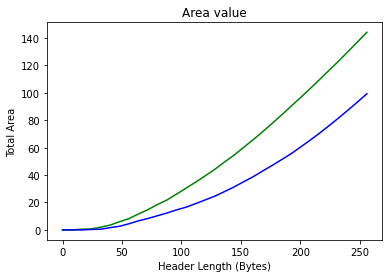

In [4]:
# Entropy-Analysis as a function of the Header-Length analyzed for the files created
area1 = np.zeros(33)
area2 = np.zeros(33)
for i in range(8,257,8):
    header_length = i
    h_ideal = entropy_analysis(ideal_file, header_length)
    h_rand_1 = entropy_analysis(file_rand_1, header_length)
    h_rand_2 = entropy_analysis(file_rand_2, header_length)
    area1[int(i/8)] = diff_area(h_ideal,h_rand_1)
    area2[int(i/8)] = diff_area(h_ideal,h_rand_2)

# Plot of the Area as a function of the Header Length analyzed for the two random file compared with the ideal file
plt.title("Area value")
plt.xlabel("Header Length (Bytes)")
plt.ylabel("Total Area")
plt.plot(x, area1, color="green")
plt.plot(x, area2, color="blue")

plt.show()

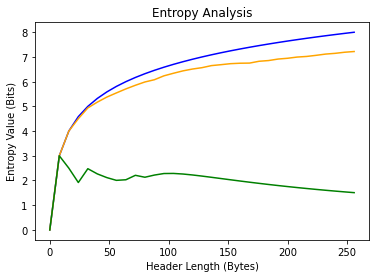

In [5]:
# Reading of the Encrypted (by a ransomware) file and the relative Decrypted file
f = open("./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny/0001-doc.doc.id-0481FA80.[paymentbtc@firemail.cc].cmb", "r", encoding='latin-1')
file_encrypted = f.read()
f = open("./NapierOneDataset/DOC/DOC-tiny/0001-doc.doc", "r", encoding='latin-1')
file_normal = f.read()

# Transformation of the two files in a vector ready to be anlyzed
size = 1024
vector_file_normal = file_to_vector(file_normal,size)
vector_file_encrypted = file_to_vector(file_encrypted,size)

# Evaluation of the Entropy-Analysis for the two files
header_length = 256
h_file_encrypted = entropy_analysis(vector_file_encrypted, header_length)
h_file_normal = entropy_analysis(vector_file_normal, header_length)

# Plot of the Entropy-Analysis of the 2 files compared to the ideal file
plt.title("Entropy Analysis")
plt.xlabel("Header Length (Bytes)")
plt.ylabel("Entropy Value (Bits)")
plt.plot(x, h_ideal, color="blue")
plt.plot(x, h_file_encrypted, color="orange")
plt.plot(x, h_file_normal, color="green")

plt.show()

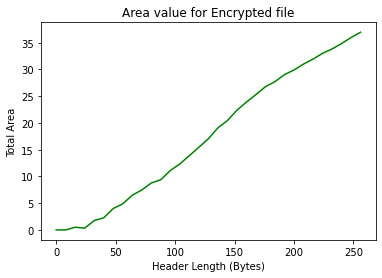

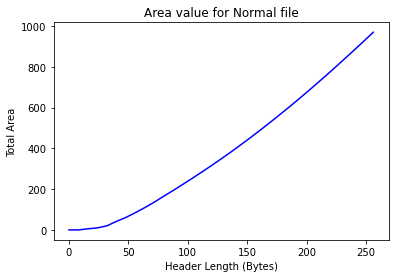

In [6]:
# Entropy-Analysis as a function of the Header Length for the files analyzed and for file_rand_1
area1 = np.zeros(33)
area2 = np.zeros(33)
for i in range(8,257,8):
    header_length = i
    h_encrypted = entropy_analysis(vector_file_encrypted, header_length)
    h_normal = entropy_analysis(vector_file_normal, header_length)
    h_rand = entropy_analysis(file_rand_1, header_length)
    area1[int(i/8)] = diff_area(h_encrypted,h_rand)
    area2[int(i/8)] = diff_area(h_normal,h_rand)

# Plot of the Area as a function of the Header Length analyzed between the two files and file_rand_1
plt.title("Area value for Encrypted file")
plt.xlabel("Header Length (Bytes)")
plt.ylabel("Total Area")
plt.plot(x, area1, color="green")
plt.show()

plt.title("Area value for Normal file")
plt.xlabel("Header Length (Bytes)")
plt.ylabel("Total Area")
plt.plot(x, area2, color="blue")
plt.show()

In [7]:
static_offset = 256
dynamic_offset = static_offset
offset = 256

ideal_file = np.zeros(static_offset)
for i in range(len(ideal_file)):
    ideal_file[i]=randint(0,255)

# Obtains all paths to analyze from a .txt files
#f = open('./paths.txt', 'r')
f = open('./paths/paths_full2.txt', 'r')
paths = f.readlines()
thresholds = np.arange(8,80,2)
f.close()

In [8]:
import time
start_time = time.time()

acc = np.zeros([len(thresholds), len(paths), 33, 1], dtype = float)
true_positives = np.zeros([len(thresholds), len(paths), int(offset/8+1), 1], dtype = float)
true_negatives = np.zeros([len(thresholds), len(paths), int(offset/8+1), 1], dtype = float)
false_positives = np.zeros([len(thresholds), len(paths), int(offset/8+1), 1], dtype = float)
false_negatives = np.zeros([len(thresholds), len(paths), int(offset/8+1), 1], dtype = float)

# Iterate over the different directories containing files to analyze
for j in range(len(paths)):
    # List all the files in the paths[j] directory
    files=os.listdir(paths[j][:-1])
    print("Start analysizng the directory", paths[j][:-1])
    files_analyzed = 0
    # Iterate over the different files in the directory paths[j]
    for object in files:
        full_path = paths[j][:-1] + "/" + object
        f=open(full_path, "r", encoding='latin-1')
        file = f.read()
        file_vector = file_to_vector(file,256)
        area = trapezoidal_rule1(ideal_file, file_vector, dynamic_offset)
        # Check if the file is really encrypted by a ransom and sum to the previous errors releted to the different header lengths the current ones,
        # storing the values
        # Iterate over different threshold values
        for i in range(len(thresholds)):
            if paths[j][19:24] == "EXTRA":
                # acc[i][j] is a vector of offset/8 values, each value represent the (TP + TN) for the differents header lengths of all the files in paths[j][:-1]
                results = accuracies1(thresholds[i], area, static_offset, True)
                acc[i][j] = np.add(acc[i][j], results[0], dtype=float)
                true_positives[i][j] = np.add(true_positives[i][j], results[1], dtype=float)
                false_positives[i][j] = np.add(false_positives[i][j], results[3], dtype=float)
            else:
                results = accuracies1(thresholds[i], area, static_offset, False)
                acc[i][j] = np.add(acc[i][j], results[0], dtype=float)
                true_negatives[i][j] = np.add(true_negatives[i][j], results[2], dtype=float)
                false_negatives[i][j] = np.add(false_negatives[i][j], results[4], dtype=float)
        files_analyzed += 1
    # acc[i][j] is a vector of 33 values, each value represent the accuracies for the differents header lengths of all the files in paths[j][:-1]
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    acc[i][j] = np.multiply(np.true_divide(acc[i][j], float(len(files))), 100.0, dtype=float)

time_spent = time.time() - start_time
print("Time for the analysis of the dataset")
print("--- %s minutes and %s seconds ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1))

Start analysizng the directory ./NapierOneDataset/DOC/DOC-tiny
Start analysizng the directory ./NapierOneDataset/DOCX/DOCX-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-MAZE-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-DHARMA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NETWALKER-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-NOTPETYA-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-PHOBOS-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-RYUK-tiny
Start analysizng the directory ./NapierOneDataset/EXTRA/RANSOMWARE-SODINOKIBI-tiny
Start analysizng the directory ./NapierOneDataset/JPG/JPG-from-web-tiny
Start analysizng the directory ./NapierOneDataset/PDF/PDF-tiny
Start analysizng the directory ./NapierOneDataset/PPTX/PPTX-tiny
Start analysizng the directory ./NapierOneDataset/XLS/XLS-tiny
Start analysizng the directory ./NapierOneDataset/X

In [9]:
# RUN CAREFULLY, YOU MAY OVERWRITE A PREVIOUSLY STORED TENSOR RELEVANT FOR THE EXPERIMENT!
# Save the tensor in the file accuracies.npy so we can recover it even without running another time the previous code
acc_reshaped = acc.reshape(np.shape(acc)[0]*np.shape(acc)[1],np.shape(acc)[2])
np.save("./accuracies/accuracies_2_fragm_analysis_countr.npy", acc_reshaped, fix_imports=False)
true_negatives_reshaped = true_negatives.reshape(np.shape(true_negatives)[0]*np.shape(true_negatives)[1],np.shape(true_negatives)[2])
np.save("./accuracies/true_negatives_trial.npy", true_negatives_reshaped, fix_imports=False)
true_positives_reshaped = true_positives.reshape(np.shape(true_positives)[0]*np.shape(true_positives)[1],np.shape(true_positives)[2])
np.save("./accuracies/true_positives_trial.npy", true_positives_reshaped, fix_imports=False)
false_negatives_reshaped = false_negatives.reshape(np.shape(false_negatives)[0]*np.shape(false_negatives)[1],np.shape(false_negatives)[2])
np.save("./accuracies/false_negatives_trial.npy", false_negatives_reshaped, fix_imports=False)
false_positives_reshaped = false_positives.reshape(np.shape(false_positives)[0]*np.shape(false_positives)[1],np.shape(false_positives)[2])
np.save("./accuracies/false_positives_trial.npy", false_positives_reshaped, fix_imports=False)

In [10]:
# deserialize the tensor from the file .npy
acc_des=np.load('./accuracies/accuracies_2_fragm_analysis_countr.npy')
acc_des = acc_des.reshape(len(thresholds), len(paths), int(static_offset/8+1))
TN_des=np.load('./accuracies/true_negatives_trial.npy')
TN_des = TN_des.reshape(len(thresholds), len(paths), int(offset/8+1))
TP_des=np.load('./accuracies/true_positives_trial.npy')
TP_des = TP_des.reshape(len(thresholds), len(paths), int(offset/8+1))
FN_des=np.load('./accuracies/false_negatives_trial.npy')
FN_des = FN_des.reshape(len(thresholds), len(paths), int(offset/8+1))
FP_des=np.load('./accuracies/false_positives_trial.npy')
FP_des = FP_des.reshape(len(thresholds), len(paths), int(offset/8+1))

In [11]:
# Shows randomly 20 accuracies of random header lengths of all files in random paths releted to the use of random thresholds
for i in range(20):
    i_thresh=randint(0, np.shape(acc_des)[0]-1)
    i_path=randint(0, np.shape(acc_des)[1]-1)
    i_hl=randint(0, np.shape(acc_des)[2]-1)
    print("%3.3f" % acc_des[i_thresh][i_path][i_hl])

100.000
100.000
100.000
69.000
100.000
92.000
62.000
100.000
100.000
100.000
81.000
0.000
100.000
81.000
98.000
100.000
0.000
100.000
100.000
100.000


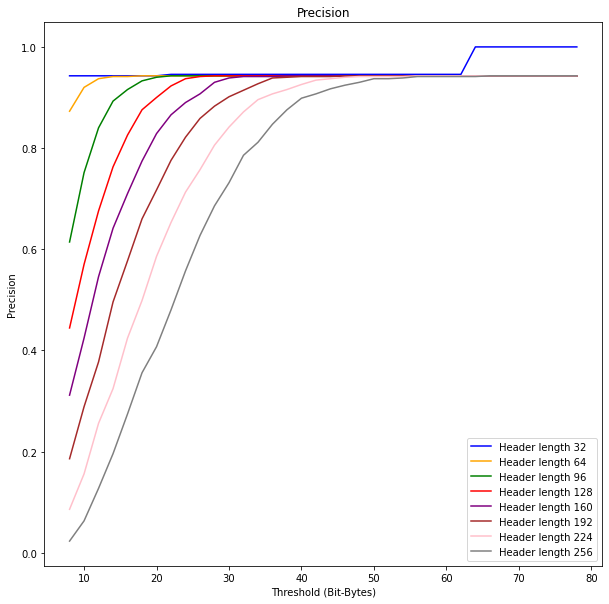

In [12]:
#Precision = TP/TP+FP

# Get for each threshold and header length the precision
hl_thresh= np.zeros([int(static_offset/8+1),len(thresholds)])
for i in range(int(static_offset/8+1)):
    for j in range(len(thresholds)):
        sumTP=0
        sumFP=0
        for k in range(len(paths)):
            sumTP=sumTP+TP_des[j][k][i]
            sumFP=sumFP+FP_des[j][k][i]
        if ((sumTP+sumFP))>0:
            hl_thresh[i][j] = sumTP/(sumTP+sumFP)

# Plot of the precision obtained using different threshold and different header lengths
plt.figure(figsize=(10,10))
plt.title("Precision")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Precision")
plt.plot(thresholds, hl_thresh[4], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[8], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[12], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[16], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[20], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[24], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[28], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[32], color="grey", label="Header length 256")
plt.legend()
plt.show()

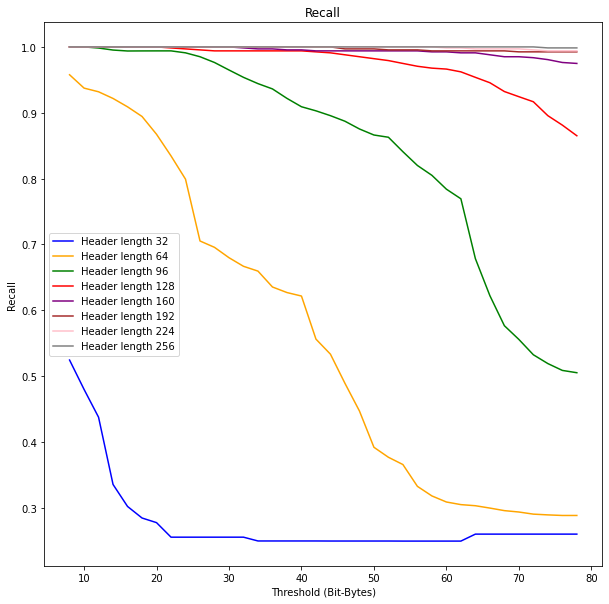

In [13]:
# Recall = TP/TP+FN

# Get for each threshold and header length the recall
hl_thresh= np.zeros([int(static_offset/8+1),len(thresholds)])
for i in range(int(static_offset/8+1)):
    for j in range(len(thresholds)):
        sumTP=0
        sumFN=0
        for k in range(len(paths)):
            sumTP=sumTP+TP_des[j][k][i]
            sumFN=sumFN+FN_des[j][k][i]
        if ((sumTP+sumFN))>0:
            hl_thresh[i][j] = sumTP/(sumTP+sumFN)

# Plot of the recall obtained using different threshold and different header lengths
plt.figure(figsize=(10,10))
plt.title("Recall")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Recall")
plt.plot(thresholds, hl_thresh[4], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[8], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[12], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[16], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[20], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[24], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[28], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[32], color="grey", label="Header length 256")
plt.legend()
plt.show()

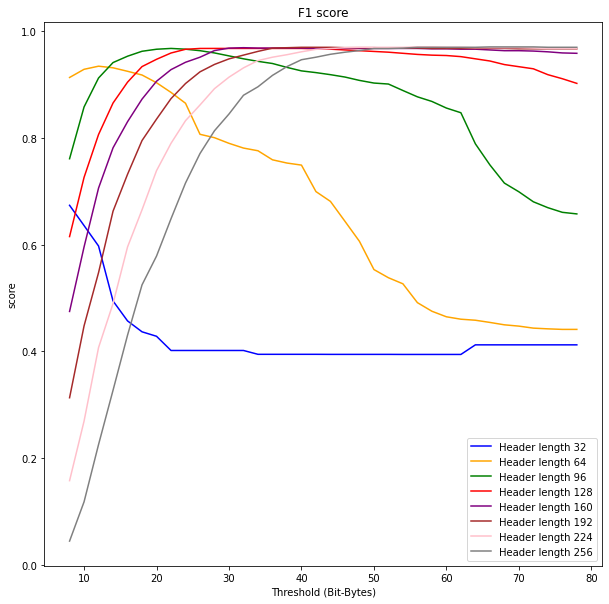

In [14]:
# F1 score = 2*(Recall * Precision) / (Recall + Precision)

# Get for each threshold and header length the f1 score
hl_thresh= np.zeros([int(static_offset/8+1),len(thresholds)])
for i in range(int(static_offset/8+1)):
    for j in range(len(thresholds)):
        sumTP=0
        sumTN=0
        sumFP=0
        sumFN=0
        for k in range(len(paths)):
            sumTP=sumTP+TP_des[j][k][i]
            sumTN=sumTN+TN_des[j][k][i]
            sumFP=sumFP+FP_des[j][k][i]
            sumFN=sumFN+FN_des[j][k][i]
        if ((sumTP+sumFN)>0) and ((sumTP+sumFP)>0) :
            precision= sumTP/(sumTP+sumFP)
            recall= sumTP/(sumTP+sumFN)
            hl_thresh[i][j] = 2*(recall*precision)/(recall+precision)
            
# Plot of the f1 score obtained using different threshold and different header lengths
plt.figure(figsize=(10,10))
plt.title("F1 score")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("score")
plt.plot(thresholds, hl_thresh[4], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[8], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[12], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[16], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[20], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[24], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[28], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[32], color="grey", label="Header length 256")
plt.legend()
plt.show()

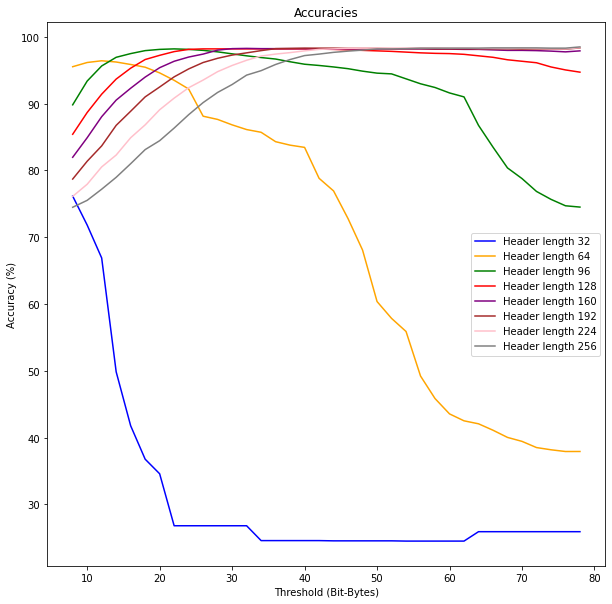

In [15]:
# Accuracy = (TP+TN)/(TP+TN+FP+FN)

# Get for each threshold and header length the total amount of accuracies
hl_thresh = np.divide(np.sum(acc_des, axis=(1)), np.shape(acc_des)[1]).transpose()

# Plot of the accuracies obtained using different threshold and different header lengths
plt.figure(figsize=(10,10))
plt.title("Accuracies")
plt.xlabel("Threshold (Bit-Bytes)")
plt.ylabel("Accuracy (%)")
plt.plot(thresholds, hl_thresh[4], color="blue", label="Header length 32")
plt.plot(thresholds, hl_thresh[8], color="orange", label="Header length 64")
plt.plot(thresholds, hl_thresh[12], color="green", label="Header length 96")
plt.plot(thresholds, hl_thresh[16], color="red", label="Header length 128")
plt.plot(thresholds, hl_thresh[20], color="purple", label="Header length 160")
plt.plot(thresholds, hl_thresh[24], color="brown", label="Header length 192")
plt.plot(thresholds, hl_thresh[28], color="pink", label="Header length 224")
plt.plot(thresholds, hl_thresh[32], color="grey", label="Header length 256")
plt.legend()
plt.show()